# Stats Memo

## Loading library and data

In [1]:
library(plyr)
library(nlme)
library(emmeans)
library(boot)
library(coin)
library(multcomp) # for glht and Tukey HSD
library(lme4)     # for glmer
library(nortest)  # for Kolmogorov-Smirnov test
library(car)      # for Anova
library(ez)       # for ezANOVA
library(ARTool)   # For ART
library(afex)     # for aov_ez

library(ggpubr)
library(grid)
library(gridExtra)

source("helper_functions.R")
source("friedman.R")

options(repr.plot.width=7, repr.plot.height=2.5)

Loading required package: survival


Attaching package: ‘survival’


The following object is masked from ‘package:boot’:

    aml


Loading required package: mvtnorm

Loading required package: TH.data

Loading required package: MASS


Attaching package: ‘TH.data’


The following object is masked from ‘package:MASS’:

    geyser


Loading required package: Matrix


Attaching package: ‘lme4’


The following object is masked from ‘package:nlme’:

    lmList


Loading required package: carData

Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4


Attaching package: ‘car’


The following object is masked from ‘package:boot’:

    logit


************
Welcome to afex. For support visit: http://afex.singmann.science/

- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values

---

## Aggregate the data

Tip 9: As many observations as participants. Perhaps the only serious mistake that can be made when computing confidence intervals is by not aggregating data. Suppose you recruit 20 subjects, show them various conditions (e.g., technique task type), and for each condition you ask them to perform 10 similar tasks. Multiple measurements can greatly help reduce statistical noise, but reporting confidence intervals based on all measurements (n = 200) would be wrong (Lazic 2010). This is because the purpose of statistical inference in HCI is typically to generalize data to a population of people (see Sect.  13.2.1 ), not of trials. 10 Measurements need to be aggregated (e.g., averaged) so that each participant ends up with a single observation before any confidence interval is computed. NHST has developed notations that make it possible for readers to spot such observations involved in the computation of confidence intervals, either in the text or in figure captions (e.g., n = 20). 

*Modern Statistical Methods for HCI - Chp5*

In [2]:
# read the data
mydata <- read.csv("Data_exp2.csv")

# create a table with aggregated data
mydata_agg = aggregate(mydata,
                by = list(mydata$roomT, mydata$condition, mydata$id),
                FUN = mean)
mydata_agg[1:3] <- list(NULL)

# create a table with aggregated data by condition
mydata_agg2 = aggregate(mydata_agg,
                by = list(mydata_agg$condition, mydata_agg$id),
                FUN = mean)
mydata_agg2[1:2] <- list(NULL)
mydata_agg2[3] <- list(NULL)

# create a table with aggregated data by roomT
mydata_agg3 = aggregate(mydata_agg,
                by = list(mydata_agg$roomT, mydata_agg$id),
                FUN = mean)
mydata_agg3[1:2] <- list(NULL)
mydata_agg3[2] <- list(NULL)

# define factors in all tables
mydata$id <- as.factor(mydata$id)
mydata$condition <- as.factor(mydata$condition)
mydata$roomT <- as.factor(mydata$roomT)

mydata_agg$id <- as.factor(mydata_agg$id)
mydata_agg$condition <- as.factor(mydata_agg$condition)
mydata_agg$roomT <- as.factor(mydata_agg$roomT)

mydata_agg2$id <- as.factor(mydata_agg2$id)
mydata_agg2$condition <- as.factor(mydata_agg2$condition)

mydata_agg3$id <- as.factor(mydata_agg3$id)
mydata_agg3$roomT <- as.factor(mydata_agg3$roomT)

In [3]:
str(mydata)

'data.frame':	288 obs. of  8 variables:
 $ id              : Factor w/ 12 levels "1","2","3","4",..: 5 5 5 5 5 5 5 5 4 4 ...
 $ condition       : Factor w/ 3 levels "0","1","2": 2 2 2 2 2 2 2 2 2 2 ...
 $ roomT           : Factor w/ 2 levels "0","1": 1 1 1 1 2 2 2 2 2 2 ...
 $ TCT             : num  38720 35336 41049 35164 32416 ...
 $ nb_warning      : int  1 10 0 2 1 2 2 0 1 3 ...
 $ nb_teleportation: int  2 2 2 2 2 3 2 3 3 5 ...
 $ walking         : num  18.05 26.26 19.54 14.86 8.51 ...
 $ rot             : num  2357 2343 2099 2205 1946 ...


In [4]:
head(mydata)

id condition roomT TCT     nb_warning nb_teleportation walking   rot     
1 5  1         0     38720.4  1         2                18.053516 2357.405
2 5  1         0     35336.5 10         2                26.258503 2342.783
3 5  1         0     41048.8  0         2                19.541346 2098.688
4 5  1         0     35163.9  2         2                14.855635 2205.154
5 5  1         1     32416.1  1         2                 8.507107 1945.900
6 5  1         1     40522.8  2         3                16.272792 2168.623

In [5]:
str(mydata_agg)

'data.frame':	72 obs. of  8 variables:
 $ id              : Factor w/ 12 levels "1","2","3","4",..: 1 1 1 1 1 1 2 2 2 2 ...
 $ condition       : Factor w/ 3 levels "0","1","2": 1 1 2 2 3 3 1 1 2 2 ...
 $ roomT           : Factor w/ 2 levels "0","1": 1 2 1 2 1 2 1 2 1 2 ...
 $ TCT             : num  91027 72210 64363 49418 48000 ...
 $ nb_warning      : num  0.5 0.5 1.75 0.5 0 1 1.25 2.75 0 0.25 ...
 $ nb_teleportation: num  20.75 17.5 3.75 6.5 2.25 ...
 $ walking         : num  12.43 2.77 17.31 13.44 16.39 ...
 $ rot             : num  3977 3353 3177 2649 2829 ...


In [6]:
head(mydata_agg)

id condition roomT TCT      nb_warning nb_teleportation walking  rot     
1 1  0         0     91026.90 0.50       20.75            12.42855 3976.551
2 1  0         1     72210.35 0.50       17.50             2.77500 3353.244
3 1  1         0     64363.20 1.75        3.75            17.31263 3176.875
4 1  1         1     49417.97 0.50        6.50            13.43713 2648.587
5 1  2         0     47999.68 0.00        2.25            16.39142 2828.762
6 1  2         1     57217.53 1.00        3.75            14.91391 2675.791

---

## Create data samples for testing distribution

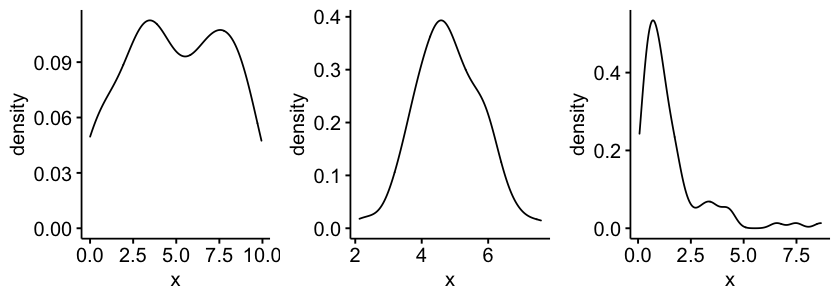

In [7]:


rand_data <- runif(100, min = 0, max = 10)
norm_data <- rnorm(100, mean = 5, sd = 1)
lnorm_data <- rlnorm(100, meanlog = 0, sdlog = 1)

ggdensity(rand_data) -> p1
ggdensity(norm_data) -> p2
ggdensity(lnorm_data) -> p3
grid.arrange(p1, p2, p3, ncol = 3)

---

## Check normal distribution

Tip 14: Do not test for normality. The world is not sharply divided into normal and non-normal distributions. This false dichotomy has been largely promoted by NHST procedures for testing normality, which are logically and practically unsound (Wierdsma 2013; Stewart-Oaten 1995, p. 2002). When computing exact confidence intervals, departures from normality are not such a big deal: as with the t test, the normality assumption does not concern the population distribution but the sampling distribution of the sample mean. 11 As per the central limit theorem, this distribution turns out to be approximately normal for almost any population distribution shape, provided that the sample size is large enough (Norman 2010, p. 628). One difficulty is that it is often unclear how large is large enough, as it also depends on how much the original population departs from a normal distribution. Another issue with exact confidence intervals is that they are necessarily symmetric, so they do not reflect skewed distributions very well and may cover impossible values. Thus there are merits to using alternative methods (see Tips 12 and 13) if there are reasons to think that the population distribution is not normal. Measurement scales that are strictly positive (e.g., time) or bounded (e.g., percents) cannot be normally distributed. Strictly positive scales are typically positively skewed and approximate a normal distribution once logged (Tip 12). When in doubt, use bootstrapping (Tip 13). 

*Modern Statistical Methods for HCI - Chp5*

This hunch can be formally tested with goodness-of-fit tests. We briefly review two popular goodness-of-fit tests here. We recommend Shapiro-Wilk for testing normality; the Kolmogorov-Smirnov test can be used to test the goodness-of-fit of non-normal distributions. For more on goodness-of-fit tests, the reader is directed elsewhere (D’Agostino 1986). 

*Modern Statistical Methods for HCI - Chp2*

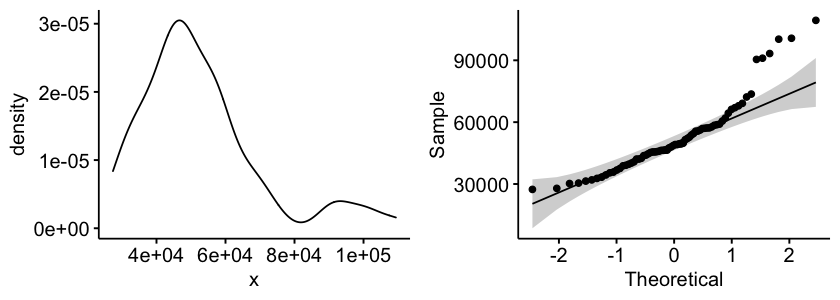

In [8]:
ggdensity(mydata_agg$TCT) -> p1
ggqqplot(mydata_agg$TCT) -> p2
grid.arrange(p1, p2, ncol = 2)

In [9]:
shapiro.test(mydata_agg$TCT)


	Shapiro-Wilk normality test

data:  mydata_agg$TCT
W = 0.887, p-value = 9.586e-06


Shapriro test is significant : the data is different from the normal distriubtion => it is not normally distributed

---

## Check log normal distribution

Tip 12: Consider the log transform. The log transform corrects for positive skewness in time measurements and gives less weight to extreme observations, thus rendering outlier removal unnecessary (Sauro and Lewis 2010). Another nice consequence is that it yields asymmetric confidence intervals, which better convey the underlying distributions and prevent the embarrassing situation where a confidence interval extends to negative values. The procedure consists in log-transforming all raw time measurements, performing all analyses as usual, then converting back (antilogging) the means and confidence interval limits at the very end, when they need to be presented numerically or graphically (Gardner and Altman 1986 , p. 749). All means will indicate geometric (instead of arithmetic) means, and differences between means will become ratios (Gardner and Altman 1986 , p. 750). As it turns out, ratios between completion times are easier to interpret than differences because they are unitless (Dragicevic 2012 ). No justification or test is needed for using a log transform on time measurements (Keene 1995 ) (see also Tip 14). 

*Modern Statistical Methods for HCI - Chp5*

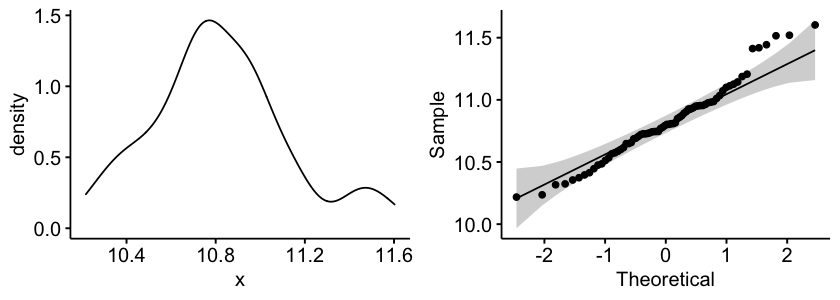

In [10]:
mydata_agg$TCT_log <- log(mydata_agg$TCT)

ggdensity(mydata_agg$TCT_log) -> p1
ggqqplot(mydata_agg$TCT_log) -> p2
grid.arrange(p1, p2, ncol = 2)

In [11]:
lillie.test(mydata_agg$TCT_log)


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  mydata_agg$TCT_log
D = 0.082685, p-value = 0.2585


Kolmogorov-Smirnov test is not significant : we can assume that the data follow a lognormal distribution.  
We will analyze the TCT with a lognormal distribution

---

## Descriptive stats and plots

In [12]:
TCT_summary_agg <- summarySEwithin(mydata_agg, 
                                   measurevar="TCT", 
                                   withinvars=c("condition", "roomT"), 
                                   idvar="id")

print(TCT_summary_agg)

  condition roomT  N      TCT TCT_norm       sd       se       ci
1         0     0 12 66786.81 66786.81 15086.25 4355.024 9585.343
2         0     1 12 61706.30 61706.30 13417.01 3873.158 8524.763
3         1     0 12 45019.82 45019.82 10814.90 3121.993 6871.461
4         1     1 12 48182.66 48182.66 10340.67 2985.094 6570.148
5         2     0 12 40723.55 40723.55 13512.72 3900.788 8585.575
6         2     1 12 51741.63 51741.63 11596.87 3347.727 7368.298


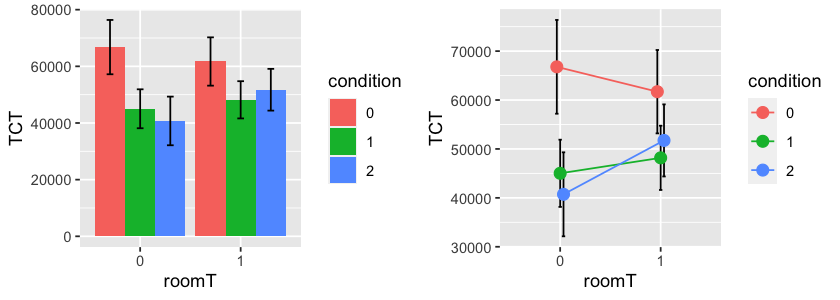

In [13]:
ggplot(TCT_summary_agg, aes(x=roomT, y=TCT, fill=condition)) +
geom_bar(stat="identity", position=position_dodge()) +
geom_errorbar(aes(ymin=TCT-ci, ymax=TCT+ci),
                  width=.2,                    # Width of the error bars
                  position=position_dodge(.9)) -> p1

# The errorbars overlapped, so use position_dodge to move them horizontally
pd <- position_dodge(0.1) # move them .05 to the left and right
ggplot(TCT_summary_agg, aes(x=roomT, y=TCT, colour=condition, group=condition)) + 
    geom_errorbar(aes(ymin=TCT-ci, ymax=TCT+ci), colour="black", width=.1, position=pd) +
    geom_line(position=pd) +
    geom_point(position=pd, size=3) -> p2

grid.arrange(p1, p2, ncol = 2)

---

## Descriptive stats and plots for log transform data

In [14]:
TCT_summary_agg1 <- summarySEwithin(mydata_agg, 
                                   measurevar="TCT_log", 
                                   withinvars=c("condition", "roomT"), 
                                   idvar="id")

Since we convert the data with a log transform, we need to convert them back to get the means and CIs for plots.

In [15]:
TCT_summary_agg1$TCT <- exp(TCT_summary_agg1$TCT_log)
TCT_summary_agg1$cup <- exp(TCT_summary_agg1$TCT_log + TCT_summary_agg1$ci)
TCT_summary_agg1$clo <- exp(TCT_summary_agg1$TCT_log - TCT_summary_agg1$ci)

print(TCT_summary_agg1)

  condition roomT  N  TCT_log TCT_log_norm        sd         se        ci
1         0     0 12 11.06690     11.06690 0.2043355 0.05898656 0.1298286
2         0     1 12 10.98520     10.98520 0.2256572 0.06514161 0.1433757
3         1     0 12 10.68636     10.68636 0.1994109 0.05756497 0.1266996
4         1     1 12 10.75719     10.75719 0.2013127 0.05811397 0.1279080
5         2     0 12 10.59165     10.59165 0.2664991 0.07693166 0.1693254
6         2     1 12 10.81721     10.81721 0.2214876 0.06393797 0.1407265
       TCT      cup      clo
1 64016.74 72891.58 56222.45
2 58994.67 68089.48 51114.66
3 43754.87 49665.10 38547.96
4 46966.59 53375.11 41327.52
5 39801.04 47144.55 33601.39
6 49871.84 57407.97 43325.01


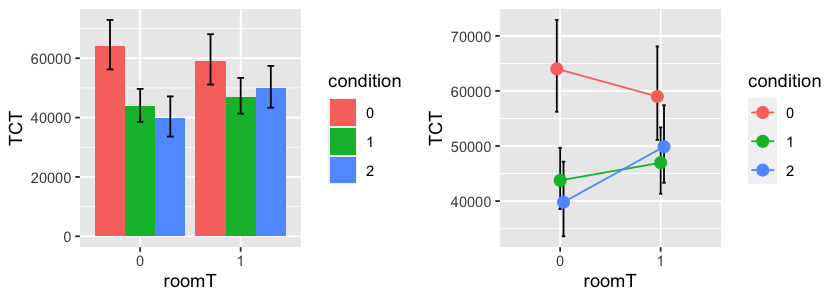

In [16]:
ggplot(TCT_summary_agg1, aes(x=roomT, y=TCT, fill=condition)) +
geom_bar(stat="identity", position=position_dodge()) +
geom_errorbar(aes(ymin=clo, ymax=cup),
                  width=.2,                    # Width of the error bars
                  position=position_dodge(.9)) -> p1

# The errorbars overlapped, so use position_dodge to move them horizontally
pd <- position_dodge(0.1) # move them .05 to the left and right
ggplot(TCT_summary_agg1, aes(x=roomT, y=TCT, colour=condition, group=condition)) + 
    geom_errorbar(aes(ymin=clo, ymax=cup), colour="black", width=.1, position=pd) +
    geom_line(position=pd) +
    geom_point(position=pd, size=3) -> p2

grid.arrange(p1, p2, ncol = 2)

---

## Descriptive stats with bootstrapping for non normally or non log normally distributed data

Tip 13: Consider bootstrapping. Bootstrapping is a very useful method that has not received enough attention (Kirby and Gerlanc 2013; Wood 2004, 2005). Briefly, it consists of generating many alternative datasets from the experimental data by randomly drawing observations with replacement. The variability across these datasets is assumed to approximate sampling error and is used to compute so-called bootstrap confidence intervals . This way of calculating confidence intervals is recent in the history of statistics because it requires computers, but it is very versatile and works for many kinds of distributions (Kirby and Gerlanc 2013). Also, since bootstrapping relies on a simple algorithm, the computer scientists in HCI may find it easier to intuitively grasp than the traditional analytical approaches (Ricketts and Berry 1994; Duckworth and Stephenson 2003). Bootstrap confidence intervals are generally accurate with about 20 observations or more (Kirby and Gerlanc 2013, p. 8), but tend to be a bit narrow with 10 or less (Wood 2005, p. 467). 

*Modern Statistical Methods for HCI - Chp5*

In [17]:
# Function for computing confidence intervals by bootstrating
# https://tonyladson.wordpress.com/2016/02/05/confidence-interval-for-the-mean-of-non-normal-data/

# Wang, F.K. (2001), Confidence interval for the mean of non‐normal data. 
# Quality and Reliability Engingeering International, 17: 257-267.https://doi.org/10.1002/qre.400

# DiCiccio, Thomas J.; Efron, Bradley. Bootstrap confidence intervals. 
# Statist. Sci. 11 (1996), no. 3, 189--228. https://dx.doi.org/10.1214/ss/1032280214

summaryWithBoot <- function(data=NULL, measurevar, groupvars=NULL,
                    conf.interval=.95, type="bca", .drop=TRUE) {
  require(boot)
    
  # function to obtain the mean
  Bmean <- function(data, i) {
      d <- data[i] # allows boot to select sample
      return(mean(d))
  }

  datac <- ddply(data, groupvars, .drop=.drop,
                 .fun = function(xx, col) {
                     bout.out <- boot(data=xx[[col]], statistic=Bmean, R=10000)
                     res <- boot.ci(bout.out, conf=conf.interval, type=c("norm","basic", "perc", "bca"))
                     c(N    = length(xx[[col]]),
                       mean = bout.out$t0,
                       clow = res[[type]][4],
                       cupp = res[[type]][5]
                   )
                 },
                 measurevar
  )
  datac <- rename(datac, c("mean" = measurevar))
  return(datac)
}

In [18]:
summary_agg2 <- summaryWithBoot(mydata_agg, measurevar="nb_warning", groupvars=c("condition", "roomT"))
print(summary_agg2)

  condition roomT  N nb_warning      clow      cupp
1         0     0 12  3.2916667 2.0208333 5.6458333
2         0     1 12  3.4583333 1.9583333 6.2718333
3         1     0 12  1.3541667 0.6666667 2.2979349
4         1     1 12  1.6458333 0.9583333 2.4583333
5         2     0 12  0.3333333 0.1250000 0.6458333
6         2     1 12  1.4583333 0.8958333 2.4791667


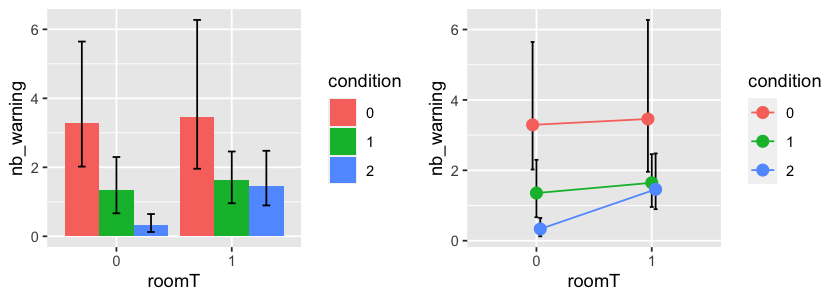

In [19]:
ggplot(summary_agg2, aes(x=roomT, y=nb_warning, fill=condition)) +
geom_bar(stat="identity", position=position_dodge()) +
geom_errorbar(aes(ymin=clow, ymax=cupp),
                  width=.2,                    # Width of the error bars
                  position=position_dodge(.9)) -> p1

# The errorbars overlapped, so use position_dodge to move them horizontally
pd <- position_dodge(0.1) # move them .05 to the left and right
ggplot(summary_agg2, aes(x=roomT, y=nb_warning, colour=condition, group=condition)) + 
    geom_errorbar(aes(ymin=clow, ymax=cupp), colour="black", width=.1, position=pd) +
    geom_line(position=pd) +
    geom_point(position=pd, size=3) -> p2

grid.arrange(p1, p2, ncol = 2)

---

# Parametric Analysis

## Two-way repeated measure Anova - Solution 1

In [20]:
res.aoc.ez <- aov_ez(id = "id", dv = "TCT_log", mydata_agg, within = c("condition","roomT"))
summary(res.aoc.ez)

Warning message in summary.Anova.mlm(object$Anova, multivariate = FALSE):
“HF eps > 1 treated as 1”



Univariate Type III Repeated-Measures ANOVA Assuming Sphericity

                Sum Sq num Df Error SS den Df    F value    Pr(>F)    
(Intercept)     8425.2      1  2.05217     11 45160.4544 < 2.2e-16 ***
condition          1.6      2  1.55984     22    11.0758 0.0004701 ***
roomT              0.1      1  0.47557     11     2.1324 0.1721794    
condition:roomT    0.3      2  0.65082     22     4.7871 0.0187925 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Mauchly Tests for Sphericity

                Test statistic p-value
condition              0.86854 0.49425
condition:roomT        0.69476 0.16187


Greenhouse-Geisser and Huynh-Feldt Corrections
 for Departure from Sphericity

                 GG eps Pr(>F[GG])    
condition       0.88381  0.0008671 ***
condition:roomT 0.76614  0.0299579 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   HF eps   Pr(>F[HF])
condition       1.0404417 0.0004701429
condition:roomT 0.8

Mauchly's Test results are not significant (condition: p = 0.49, condition X roomT: p = 0.16),  
indicating that sphericity is not violated and that an uncorrected test can be used.

Main effect of condition (F(2,22) = 11.08, p = 0.0005)  
Interaction effect of condition X roomT (F(2,22) = 4.79, p = 0.019) 

In [21]:
res.aoc.ez2 <- aov_ez(id = "id", dv = "walking", mydata_agg, within = c("condition","roomT"))
summary(res.aoc.ez2)


Univariate Type III Repeated-Measures ANOVA Assuming Sphericity

                 Sum Sq num Df Error SS den Df  F value    Pr(>F)    
(Intercept)     14342.8      1   680.91     11 231.7067 9.763e-09 ***
condition          39.5      2   607.07     22   0.7165    0.4995    
roomT              11.3      1   153.55     11   0.8075    0.3881    
condition:roomT     4.4      2   155.81     22   0.3106    0.7361    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Mauchly Tests for Sphericity

                Test statistic  p-value
condition              0.23105 0.000658
condition:roomT        0.56427 0.057203


Greenhouse-Geisser and Huynh-Feldt Corrections
 for Departure from Sphericity

                 GG eps Pr(>F[GG])
condition       0.56531     0.4302
condition:roomT 0.69651     0.6594

                   HF eps Pr(>F[HF])
condition       0.5860221  0.4345933
condition:roomT 0.7659106  0.6797188

Mauchly's Test results are significant for condition: p = 0.0007, indicating that sphericity is violated  
and that the corrected p-value (p\[GG\]) must be used (Greenhouse-Geisser correction).  
=> No significant effects detected.

#### Post-hoc analysis of the main effect - t-Test with bonferroni correction

In [22]:
ls2 <- lsmeans(res.aoc.ez, c("condition"))
update(pairs(ls2), by=NULL, adjust = "bonferroni")

# is the same than:
# contrast(ls2,method="pairwise",adjust="bonferroni")

NOTE: Results may be misleading due to involvement in interactions



 contrast estimate     SE df t.ratio p.value
 X0 - X1    0.3043 0.0769 22 3.958   0.0020 
 X0 - X2    0.3216 0.0769 22 4.184   0.0012 
 X1 - X2    0.0173 0.0769 22 0.226   1.0000 

Results are averaged over the levels of: roomT 
P value adjustment: bonferroni method for 3 tests 

#### Post-hoc analysis of the main effect - Tukey HSD

In [23]:
pairs(ls2)

 contrast estimate     SE df t.ratio p.value
 X0 - X1    0.3043 0.0769 22 3.958   0.0019 
 X0 - X2    0.3216 0.0769 22 4.184   0.0011 
 X1 - X2    0.0173 0.0769 22 0.226   0.9724 

Results are averaged over the levels of: roomT 
P value adjustment: tukey method for comparing a family of 3 estimates 

#### Post-hoc analysis of the interaction effect - Paired t-tests

In [24]:
ls1 <- emmeans(res.aoc.ez, ~condition|roomT)
# is the same than: emmeans(res.aoc.ez, c("condition"), by="roomT"))

update(pairs(ls1), by=NULL, adjust = "none")

 contrast roomT estimate     SE   df t.ratio p.value
 X0 - X1  X0      0.3805 0.0915 37.6  4.159  0.0002 
 X0 - X2  X0      0.4753 0.0915 37.6  5.194  <.0001 
 X1 - X2  X0      0.0947 0.0915 37.6  1.035  0.3073 
 X0 - X1  X1      0.2280 0.0915 37.6  2.492  0.0172 
 X0 - X2  X1      0.1680 0.0915 37.6  1.836  0.0743 
 X1 - X2  X1     -0.0600 0.0915 37.6 -0.656  0.5159 


#### Post-hoc analysis of the interaction effect - Paired t-tests (bonferroni correction)

In [25]:
update(pairs(ls1), by=NULL, adjust = "bonferroni") 
# is the same than:
# comps <- contrast(ls1,method="pairwise")
# print(summary(comps,by=NULL,adjust="bonferroni"))

 contrast roomT estimate     SE   df t.ratio p.value
 X0 - X1  X0      0.3805 0.0915 37.6  4.159  0.0011 
 X0 - X2  X0      0.4753 0.0915 37.6  5.194  <.0001 
 X1 - X2  X0      0.0947 0.0915 37.6  1.035  1.0000 
 X0 - X1  X1      0.2280 0.0915 37.6  2.492  0.1034 
 X0 - X2  X1      0.1680 0.0915 37.6  1.836  0.4458 
 X1 - X2  X1     -0.0600 0.0915 37.6 -0.656  1.0000 

P value adjustment: bonferroni method for 6 tests 

#### Post-hoc analysis of the interaction effect - Paired t-tests (holm - bonferroni correction)

In [26]:
update(pairs(ls1), by=NULL, adjust = "holm") 

 contrast roomT estimate     SE   df t.ratio p.value
 X0 - X1  X0      0.3805 0.0915 37.6  4.159  0.0009 
 X0 - X2  X0      0.4753 0.0915 37.6  5.194  <.0001 
 X1 - X2  X0      0.0947 0.0915 37.6  1.035  0.6146 
 X0 - X1  X1      0.2280 0.0915 37.6  2.492  0.0690 
 X0 - X2  X1      0.1680 0.0915 37.6  1.836  0.2229 
 X1 - X2  X1     -0.0600 0.0915 37.6 -0.656  0.6146 

P value adjustment: holm method for 6 tests 

#### Post-hoc analysis of the interaction effect - Tukey HSD

It is not necessary to correct for multiple comparisons when using Tukey's HSD. The procedure was developed specifically to account for multiple comparison and maintains experiment-wise alpha at the specified level (conventionally .05). Page 210 of Maxwell and Delaney's book on experimental design has explanations and examples of the procedure.

https://stats.stackexchange.com/questions/33357/does-the-tukey-hsd-test-correct-for-multiple-comparisons?rq=1

In [27]:
pairs(ls1)

roomT = X0:
 contrast estimate     SE   df t.ratio p.value
 X0 - X1    0.3805 0.0915 37.6  4.159  0.0005 
 X0 - X2    0.4753 0.0915 37.6  5.194  <.0001 
 X1 - X2    0.0947 0.0915 37.6  1.035  0.5598 

roomT = X1:
 contrast estimate     SE   df t.ratio p.value
 X0 - X1    0.2280 0.0915 37.6  2.492  0.0444 
 X0 - X2    0.1680 0.0915 37.6  1.836  0.1719 
 X1 - X2   -0.0600 0.0915 37.6 -0.656  0.7902 

P value adjustment: tukey method for comparing a family of 3 estimates 

---

## Two-way repeated measure Anova - Solution 2

In [28]:
aov.ez1 <- ezANOVA(data=mydata_agg,dv=.(TCT_log), wid=.(id), within =.(condition,roomT), detailed=TRUE)
aov.ez1

$ANOVA
           Effect DFn DFd          SSn       SSd            F            p
1     (Intercept)   1  11 8.425191e+03 2.0521739 45160.454428 3.142961e-21
2       condition   2  22 1.570599e+00 1.5598449    11.075840 4.701429e-04
3           roomT   1  11 9.219187e-02 0.4755726     2.132399 1.721794e-01
4 condition:roomT   2  22 2.832332e-01 0.6508207     4.787133 1.879246e-02
  p<.05        ges
1     * 0.99943791
2     * 0.24894540
3       0.01908496
4     * 0.05640247

$`Mauchly's Test for Sphericity`
           Effect         W         p p<.05
2       condition 0.8685381 0.4942473      
4 condition:roomT 0.6947582 0.1618708      

$`Sphericity Corrections`
           Effect       GGe        p[GG] p[GG]<.05       HFe        p[HF]
2       condition 0.8838123 0.0008671476         * 1.0404417 0.0004701429
4 condition:roomT 0.7661416 0.0299578846         * 0.8654356 0.0245603339
  p[HF]<.05
2         *
4         *

---

## Two-way repeated measure Anova - Solution 3

In [29]:
aov.agg <- aov(TCT_log ~ condition * roomT + Error(id / (condition * roomT)), data=mydata_agg)
summary(aov.agg)


Error: id
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 11  2.052  0.1866               

Error: id:condition
          Df Sum Sq Mean Sq F value  Pr(>F)    
condition  2  1.571  0.7853   11.08 0.00047 ***
Residuals 22  1.560  0.0709                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: id:roomT
          Df Sum Sq Mean Sq F value Pr(>F)
roomT      1 0.0922 0.09219   2.132  0.172
Residuals 11 0.4756 0.04323               

Error: id:condition:roomT
                Df Sum Sq Mean Sq F value Pr(>F)  
condition:roomT  2 0.2832 0.14162   4.787 0.0188 *
Residuals       22 0.6508 0.02958                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

---

## Post-hoc analysis of the main effect with t-test

In [30]:
pairwise.t.test(mydata_agg$TCT_log,mydata_agg$condition,paired=TRUE,p.adjust.method="bonferroni")


	Pairwise comparisons using paired t tests 

data:  mydata_agg$TCT_log and mydata_agg$condition 

  0       1      
1 0.00017 -      
2 0.00152 1.00000

P value adjustment method: bonferroni 

---

## Post-hoc analysis of the interaction effect with t-test - Solution 1

*/!\ all p-values are multiplied by 15 with bonferroni correction (because we do 15 tests)  
=> that is maybe too much? too conservative?*

In [31]:
pairwise.t.test(mydata_agg$TCT_log,
                interaction(mydata_agg$condition,mydata_agg$roomT),
                paired=TRUE,
                p.adjust.method="bonferroni")

# Is the same than :
# pairwise.t.test(mydata_agg$TCT_log,
#                mydata_agg$condition:mydata_agg$roomT,
#                paired=TRUE,
#                p.adjust.method="bonferroni")


	Pairwise comparisons using paired t tests 

data:  mydata_agg$TCT_log and interaction(mydata_agg$condition, mydata_agg$roomT) 

    0.0   1.0   2.0   0.1   1.1  
1.0 0.030 -     -     -     -    
2.0 0.021 1.000 -     -     -    
0.1 1.000 0.257 0.069 -     -    
1.1 0.043 1.000 1.000 0.201 -    
2.1 0.209 1.000 0.586 1.000 1.000

P value adjustment method: bonferroni 

---

## Post-hoc analysis of the interaction effect with t-test - Solution 2

*/!\ all p-values are multiplied by 3 with bonferroni correction (because we do 3 tests)  
=> that is maybe not enough? we do 6 test in that case?*

In [32]:
roomT0 <- subset(mydata_agg, roomT == "0")
roomT1 <- subset(mydata_agg, roomT == "1")

pairwise.t.test(roomT0$TCT_log, roomT0$condition,paired=TRUE,p.adjust.method="bonferroni")
pairwise.t.test(roomT1$TCT_log, roomT1$condition,paired=TRUE,p.adjust.method="bonferroni")


	Pairwise comparisons using paired t tests 

data:  roomT0$TCT_log and roomT0$condition 

  0      1     
1 0.0060 -     
2 0.0042 0.6001

P value adjustment method: bonferroni 


	Pairwise comparisons using paired t tests 

data:  roomT1$TCT_log and roomT1$condition 

  0    1   
1 0.04 -   
2 0.34 1.00

P value adjustment method: bonferroni 

---

## Post-hoc analysis of the interaction effect with Tukey HSD

*/!\ I am not sure that this is correct!  
=> for Tukey HSD check maybe repeated measure anova - Solution 1*

In [33]:
roomT0.mod <- lme(TCT_log ~ condition, random=~1|id, data=roomT0, method="ML")
roomT1.mod <- lme(TCT_log ~ condition, random=~1|id, data=roomT1, method="ML")

tu3 <- glht(roomT0.mod, linfct=mcp(condition = "Tukey"))
tu4 <- glht(roomT1.mod, linfct=mcp(condition = "Tukey"))

summary(tu3)
summary(tu4)


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lme.formula(fixed = TCT_log ~ condition, data = roomT0, random = ~1 | 
    id, method = "ML")

Linear Hypotheses:
           Estimate Std. Error z value Pr(>|z|)    
1 - 0 == 0 -0.38054    0.08977  -4.239   <1e-04 ***
2 - 0 == 0 -0.47525    0.08977  -5.294   <1e-04 ***
2 - 1 == 0 -0.09471    0.08977  -1.055    0.542    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)



	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lme.formula(fixed = TCT_log ~ condition, data = roomT1, random = ~1 | 
    id, method = "ML")

Linear Hypotheses:
           Estimate Std. Error z value Pr(>|z|)  
1 - 0 == 0 -0.22801    0.08540  -2.670   0.0208 *
2 - 0 == 0 -0.16799    0.08540  -1.967   0.1204  
2 - 1 == 0  0.06002    0.08540   0.703   0.7618  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)


---

# Non-parametric tests

## Wilcoxon signed rank test for Within-subject

In [34]:
wilcoxsign_test(nb_warning ~ roomT | id, data=mydata_agg3, dist="exact")


	Exact Wilcoxon-Pratt Signed-Rank Test

data:  y by x (pos, neg) 
	 stratified by block
Z = -1.2551, p-value = 0.2334
alternative hypothesis: true mu is not equal to 0


In [35]:
wilcox.test(subset(mydata_agg3, roomT == "0")$nb_warning, subset(mydata_agg3, roomT == "1")$nb_warning, paired = TRUE)


	Wilcoxon signed rank test

data:  subset(mydata_agg3, roomT == "0")$nb_warning and subset(mydata_agg3, roomT == "1")$nb_warning
V = 23, p-value = 0.2334
alternative hypothesis: true location shift is not equal to 0


---

## Friedman test

In [36]:
friedman.test(nb_warning ~ condition | id, data=mydata_agg2 )


	Friedman rank sum test

data:  nb_warning and condition and id
Friedman chi-squared = 11.511, df = 2, p-value = 0.003165


---

## Friedman test with post hoc analysis

friedman.test.with.post.hoc uses "Wilcoxon-Nemenyi-McDonald-Thompson" tests for post hoc analysis (*Nonparametric Statistical Methods, 2nd Edition [Hardcover], Hollander & Wolfe (1999)*).  
It does not require to adjust p-value for multi-comparison testings according to the author of the code. The advantage of this post hoc method is that it is (probably) more powerful then what you will get using Bonferroni (which can be too conservative sometimes).  
https://www.r-statistics.com/2010/02/post-hoc-analysis-for-friedmans-test-r-code/

Loading required package: colorspace



$Friedman.Test

	Asymptotic General Symmetry Test

data:  nb_warning by condition (0, 1, 2) 
	 stratified by id
maxT = 3.3731, p-value = 0.00221
alternative hypothesis: two.sided


$PostHoc.Test
                 
1 - 0 0.111509116
2 - 0 0.002131713
2 - 1 0.356544781


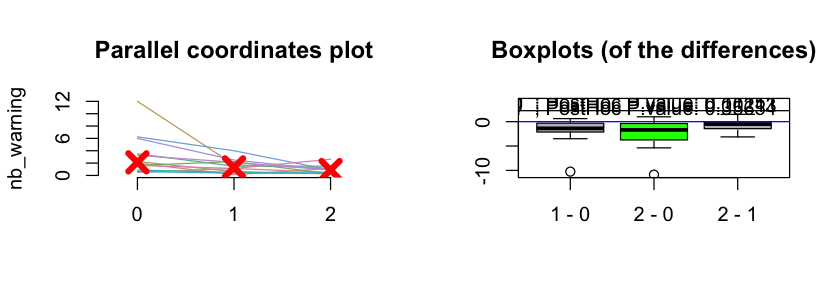

In [37]:
friedman.test.with.post.hoc(nb_warning ~ condition | id, data=mydata_agg2)

---

## Friedman test on sub-conditions

In [38]:
roomT0 <- subset(mydata_agg, roomT == "0")
roomT1 <- subset(mydata_agg, roomT == "1")

friedman.test(nb_warning ~ condition | id, data=roomT0 )
friedman.test(nb_warning ~ condition | id, data=roomT1 )


	Friedman rank sum test

data:  nb_warning and condition and id
Friedman chi-squared = 14.279, df = 2, p-value = 0.0007931



	Friedman rank sum test

data:  nb_warning and condition and id
Friedman chi-squared = 4.9545, df = 2, p-value = 0.08397


---

## Paired Wilcoxon signed rank tests with bonferroni correction

In [39]:
pairwise.wilcox.test(mydata_agg2$nb_warning,
                     mydata_agg2$condition,
                     p.adjust.method="bonferroni",
                     paired=T)

Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with zeroes”



	Pairwise comparisons using Wilcoxon signed rank test 

data:  mydata_agg2$nb_warning and mydata_agg2$condition 

  0     1    
1 0.062 -    
2 0.034 0.378

P value adjustment method: bonferroni 

---

## Paired Wilcoxon signed rank tests with holm-bonferroni correction

I’d say that the following should also be a good (and simple) post-hoc test "pairwise.wilcox.test". In this example there are several measures in each group (one measure per block). Here, the block is implicit (it is taken into account through paired=T). The Holm method for multiple-testing corrections is less conservative than Bonferroni.

*Post on: https://www.r-statistics.com/2010/02/post-hoc-analysis-for-friedmans-test-r-code/*

In [40]:
pairwise.wilcox.test(mydata_agg2$nb_warning,
                     mydata_agg2$condition,
                     p.adjust.method="holm",
                     paired=T)

Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with zeroes”



	Pairwise comparisons using Wilcoxon signed rank test 

data:  mydata_agg2$nb_warning and mydata_agg2$condition 

  0     1    
1 0.041 -    
2 0.034 0.126

P value adjustment method: holm 

---

## Post-Hoc Analysis with Wilcoxon signed rank test

_**Attention => no correction for multiple comparisons**_

In [41]:
wilcox.test(subset(mydata_agg2, condition == "0")$nb_warning, subset(mydata_agg2, condition == "1")$nb_warning, paired = TRUE)
wilcox.test(subset(mydata_agg2, condition == "0")$nb_warning, subset(mydata_agg2, condition == "2")$nb_warning, paired = TRUE)
wilcox.test(subset(mydata_agg2, condition == "1")$nb_warning, subset(mydata_agg2, condition == "2")$nb_warning, paired = TRUE)

Warning message in wilcox.test.default(subset(mydata_agg2, condition == "0")$nb_warning, :
“cannot compute exact p-value with ties”



	Wilcoxon signed rank test with continuity correction

data:  subset(mydata_agg2, condition == "0")$nb_warning and subset(mydata_agg2, condition == "1")$nb_warning
V = 69, p-value = 0.02061
alternative hypothesis: true location shift is not equal to 0


Warning message in wilcox.test.default(subset(mydata_agg2, condition == "0")$nb_warning, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(subset(mydata_agg2, condition == "0")$nb_warning, :
“cannot compute exact p-value with zeroes”



	Wilcoxon signed rank test with continuity correction

data:  subset(mydata_agg2, condition == "0")$nb_warning and subset(mydata_agg2, condition == "2")$nb_warning
V = 62, p-value = 0.01124
alternative hypothesis: true location shift is not equal to 0


Warning message in wilcox.test.default(subset(mydata_agg2, condition == "1")$nb_warning, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(subset(mydata_agg2, condition == "1")$nb_warning, :
“cannot compute exact p-value with zeroes”



	Wilcoxon signed rank test with continuity correction

data:  subset(mydata_agg2, condition == "1")$nb_warning and subset(mydata_agg2, condition == "2")$nb_warning
V = 43, p-value = 0.126
alternative hypothesis: true location shift is not equal to 0


It is the same than doing the paired wilcoxon test without correction!

In [42]:
pairwise.wilcox.test(mydata_agg2$nb_warning,
                     mydata_agg2$condition,
                     p.adjust.method="none",
                     paired=T)

Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with zeroes”



	Pairwise comparisons using Wilcoxon signed rank test 

data:  mydata_agg2$nb_warning and mydata_agg2$condition 

  0     1    
1 0.021 -    
2 0.011 0.126

P value adjustment method: none 

---

## Analysis with ART methods

http://depts.washington.edu/acelab/proj/art/index.html

In [43]:
mod.art2 <- art(nb_teleportation ~ condition * roomT + (1|id), data=mydata_agg)
print(anova(mod.art2))

Analysis of Variance of Aligned Rank Transformed Data

Table Type: Analysis of Deviance Table (Type III Wald F tests with Kenward-Roger df) 
Model: Mixed Effects (lmer)
Response: art(nb_teleportation)

                         F Df Df.res     Pr(>F)    
1 condition       90.39597  2     55 < 2.22e-16 ***
2 roomT            0.51961  1     55  0.4740618    
3 condition:roomT  5.95361  2     55  0.0045653  **
---
Signif. codes:   0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 


### Post-hoc analysis of the main effect

In [44]:
lsmeans(artlm(mod.art2, "condition"), pairwise ~ condition)

NOTE: Results may be misleading due to involvement in interactions



$lsmeans
 condition lsmean   SE   df lower.CL upper.CL
 0           60.3 2.75 30.4     54.7     65.9
 1           20.6 2.75 30.4     15.0     26.2
 2           28.6 2.75 30.4     23.0     34.2

Results are averaged over the levels of: roomT 
Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$contrasts
 contrast estimate   SE df t.ratio p.value
 0 - 1       39.67 3.12 55 12.715  <.0001 
 0 - 2       31.65 3.12 55 10.144  <.0001 
 1 - 2       -8.02 3.12 55 -2.571  0.0339 

Results are averaged over the levels of: roomT 
Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 3 estimates 


### Post-hoc analysis of the interaction effect - Solution 1

In [45]:
library(phia)
res <- testInteractions(artlm(mod.art2, "condition:roomT"), pairwise=c("condition","roomT"), adjustment="holm")
print(res)

Chisq Test: 
P-value adjustment method: holm
           Value Df   Chisq Pr(>Chisq)   
0-1 : 0-1 19.917  1  4.2564   0.078206 . 
0-2 : 0-1 33.083  1 11.7443   0.001831 **
1-2 : 0-1 13.167  1  1.8602   0.172602   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Post-hoc analysis of the interaction effect - Solution 2

In [46]:
# cross-factor pairwise comparisons using Wilcoxon signed-rank tests.
# we don't have to do all six possible comparisons over X1=(a,b),
# X2=(d,e), but we do so below for completeness. Note each comparison
# assumes subjects were in both of the compared conditions.
library(reshape2)
mydata_wide <- dcast(mydata_agg, id ~ condition + roomT, value.var="nb_teleportation") # make wide-format table
c00_vs_c10 = wilcox.test(mydata_wide$`0_0`, mydata_wide$`1_0`, paired=TRUE)$p.value
c00_vs_c20 = wilcox.test(mydata_wide$`0_0`, mydata_wide$`2_0`, paired=TRUE)$p.value
c10_vs_c20 = wilcox.test(mydata_wide$`1_0`, mydata_wide$`2_0`, paired=TRUE)$p.value
c01_vs_c11 = wilcox.test(mydata_wide$`0_1`, mydata_wide$`1_1`, paired=TRUE)$p.value
c01_vs_c21 = wilcox.test(mydata_wide$`0_1`, mydata_wide$`2_1`, paired=TRUE)$p.value
c11_vs_c21 = wilcox.test(mydata_wide$`1_1`, mydata_wide$`2_1`, paired=TRUE)$p.value
c00_vs_c01 = wilcox.test(mydata_wide$`0_0`, mydata_wide$`0_1`, paired=TRUE)$p.value
c10_vs_c11 = wilcox.test(mydata_wide$`1_0`, mydata_wide$`1_1`, paired=TRUE)$p.value
c20_vs_c21 = wilcox.test(mydata_wide$`2_0`, mydata_wide$`2_1`, paired=TRUE)$p.value

# correct for multiple comparisons using Holm's sequential Bonferroni procedure (Holm 1979)
p.adjust(c(c00_vs_c10, c00_vs_c20, c10_vs_c20, 
           c01_vs_c11, c01_vs_c21, c11_vs_c21,
           c00_vs_c01, c10_vs_c11, c20_vs_c21), method="holm")

Warning message in wilcox.test.default(mydata_wide$`0_0`, mydata_wide$`1_0`, paired = TRUE):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mydata_wide$`0_0`, mydata_wide$`2_0`, paired = TRUE):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mydata_wide$`1_0`, mydata_wide$`2_0`, paired = TRUE):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mydata_wide$`1_0`, mydata_wide$`2_0`, paired = TRUE):
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(mydata_wide$`0_1`, mydata_wide$`2_1`, paired = TRUE):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mydata_wide$`1_1`, mydata_wide$`2_1`, paired = TRUE):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mydata_wide$`1_1`, mydata_wide$`2_1`, paired = TRUE):
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(mydata_wide$`0_0`, 

[1] 0.020131973 0.020131973 0.903917310 0.004394531 0.020131973 0.283552634
[7] 0.126286118 0.221780198 0.221780198

---

## Analysis with Generalized Linear Mixed Model

In [47]:
contrasts(mydata_agg$condition) <- "contr.sum"
contrasts(mydata_agg$roomT) <- "contr.sum"

m <- glmer(nb_teleportation ~ condition * roomT + (1|id), data=mydata_agg, family = Gamma(link="log"))
res.glmm <- Anova(m, type=3)
print(res.glmm)

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: nb_teleportation
                   Chisq Df Pr(>Chisq)    
(Intercept)     221.8062  1  < 2.2e-16 ***
condition       292.4236  2  < 2.2e-16 ***
roomT             3.9085  1   0.048043 *  
condition:roomT  10.4367  2   0.005416 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
